In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import xgboost
import optuna
import pickle
import matplotlib
import plotly

## Data Loading

In [2]:
! ls

data
demo_service
mlflow.db
mlruns
model_as_a_pyfunc.ipynb
models
prompt_optimization_tweet_generation_example.ipynb
README.md
regression_experiment.ipynb
requirements.txt
script.py
shap_model_interpretation.ipynb


In [2]:
!mkdir data

In [3]:
!mkdir models

In [5]:
files = [('green_tripdata_2025-02.parquet', './data'), 
         ('green_tripdata_2025-03.parquet', './data')]

print("Downloading started:...")

for file, path in files:
    url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    save_path = f"{path}/{file}"
    response = requests.get(url, stream=True)

    with open(save_path, "wb") as handle:
        for data in response.iter_content(chunk_size=1024):
            handle.write(data)
    

In [9]:
! wc -l data/green_tripdata_2025-06.parquet

    5075 data/green_tripdata_2025-06.parquet


In [3]:
train_data = pd.read_parquet("data/green_tripdata_2025-05.parquet")
test_data = pd.read_parquet("data/green_tripdata_2025-06.parquet")

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55399 entries, 0 to 55398
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               55399 non-null  int32         
 1   lpep_pickup_datetime   55399 non-null  datetime64[us]
 2   lpep_dropoff_datetime  55399 non-null  datetime64[us]
 3   store_and_fwd_flag     52155 non-null  object        
 4   RatecodeID             52155 non-null  float64       
 5   PULocationID           55399 non-null  int32         
 6   DOLocationID           55399 non-null  int32         
 7   passenger_count        52155 non-null  float64       
 8   trip_distance          55399 non-null  float64       
 9   fare_amount            55399 non-null  float64       
 10  extra                  55399 non-null  float64       
 11  mta_tax                55399 non-null  float64       
 12  tip_amount             55399 non-null  float64       
 13  t

In [ ]:
train_data.info()

In [4]:
num_features = ['total_amount', 'trip_distance', 'passenger_count']
cat_features = ['PULocationID', 'DOLocationID']

In [5]:
def preprocessing(data):
    data['duration'] = data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']
    data.duration = data.duration.apply(lambda td: td.total_seconds()/60)
    data = data[(data.duration >= 3.) & (data.duration <= 120.)] 
    data.fillna(0, inplace=True) #maybe debug this later
    return data

In [6]:
train_tmp = preprocessing(train_data)
X_train = train_tmp[num_features + cat_features]
y_train = train_tmp['duration']

/var/folders/90/8_2t0pfn6svg2_9zl_0rfx3w0000gn/T/ipykernel_52195/616008877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True) #maybe debug this later


<Axes: >

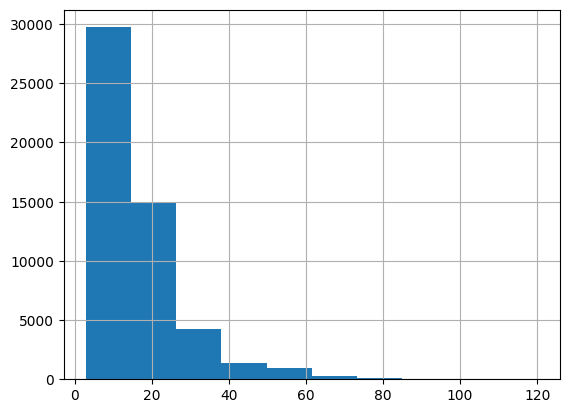

In [17]:
train_tmp.duration.hist()

In [7]:
X_test = preprocessing(test_data)[num_features + cat_features]
y_test = preprocessing(test_data)['duration']

/var/folders/90/8_2t0pfn6svg2_9zl_0rfx3w0000gn/T/ipykernel_52195/616008877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True) #maybe debug this later
/var/folders/90/8_2t0pfn6svg2_9zl_0rfx3w0000gn/T/ipykernel_52195/616008877.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True) #maybe debug this later


## Baseline model

In [8]:
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [9]:
train_pred = model.predict(X_train)
root_mean_squared_error(train_pred, y_train)

8.399710336414241

In [ ]:
train_tmp.duration.hist()

(array([2.0000e+00, 3.0000e+00, 1.2500e+02, 4.9998e+04, 1.4170e+03,
        9.5000e+01, 6.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-93.02590504, -60.2191918 , -27.41247857,   5.39423467,
         38.20094791,  71.00766115, 103.81437438, 136.62108762,
        169.42780086, 202.2345141 , 235.04122734]),
 <BarContainer object of 10 artists>)

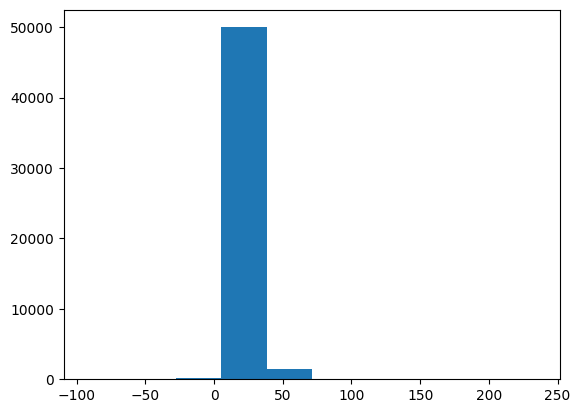

In [24]:
matplotlib.pyplot.hist(train_pred)

In [22]:
train_pred

numpy.ndarray

In [10]:
test_pred = model.predict(X_test)
root_mean_squared_error(test_pred, y_test)

8.860860707286978

In [12]:
with open("models/lin_reg.pkl", "wb") as f_out:
    pickle.dump(model, f_out)

In [13]:
! ls models

lin_reg.pkl


## Experiments

In [26]:
import mlflow

In [27]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")

In [28]:
mlflow.set_experiment("regression_experiment")

2025/07/28 11:14:32 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/28 11:14:32 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/Users/emelidral/Dev/a_experiments_2025/mlruns/1', creation_time=1753694072489, experiment_id='1', last_update_time=1753694072489, lifecycle_stage='active', name='regression_experiment', tags={}>

In [30]:
with mlflow.start_run():
    alpha=0.5
    model = Lasso(alpha)
    mlflow.log_param("alpha", alpha)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, test_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.set_tag("workspace", "classwork")

In [32]:
with mlflow.start_run():
    alpha=0.5
    model = Lasso(alpha)
    mlflow.log_param("alpha", alpha)
    model.fit(X_train, y_train)
    test_preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, test_pred)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_artifact("data/green_tripdata_2025-05.parquet")
    mlflow.log_artifact("data/green_tripdata_2025-06.parquet")
    mlflow.set_tag("workspace", "classwork")

## Auto logging

In [36]:
mlflow.sklearn.autolog()
alpha=0.2
model = Lasso(alpha)
model.fit(X_train, y_train)

2025/07/28 11:41:13 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 1.3.0 <= scikit-learn <= 1.7.0, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/07/28 11:41:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/homebrew/Caskroom/miniconda/base/envs/inclass_env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (floa

In [34]:
mlflow.sklearn.autolog()
alpha=0.7
model = Lasso(alpha)
model.fit(X_train, y_train)
test_preds = model.predict(X_test)
mlflow.log_metric("rmse", root_mean_squared_error(y_test, test_pred))

2025/07/28 11:38:33 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 1.3.0 <= scikit-learn <= 1.7.0, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/07/28 11:38:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0bfe63aa63f6478ebe0627846e0391b5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/07/28 11:38:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/homebrew/Caskroom/miniconda/base/envs/inclass_env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded a

In [39]:
mlflow.end_run()

In [44]:
mlflow.set_experiment("lasso alpha regression")

2025/07/28 11:52:28 INFO mlflow.tracking.fluent: Experiment with name 'lasso alpha regression' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/emelidral/Dev/a_experiments_2025/mlruns/2', creation_time=1753696348713, experiment_id='2', last_update_time=1753696348713, lifecycle_stage='active', name='lasso alpha regression', tags={}>

In [46]:
with mlflow.start_run():
    for alpha in range(0, 100, 5):
        with mlflow.start_run(nested=True):
            model = Lasso(alpha/100)
            mlflow.log_param("alpha", alpha/100)
            model.fit(X_train, y_train)
            test_preds = model.predict(X_test)
            rmse = root_mean_squared_error(y_test, test_pred)
            mlflow.log_metric("rmse", rmse)

2025/07/28 11:54:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/homebrew/Caskroom/miniconda/base/envs/inclass_env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
/opt/homebrew/Caskroom/miniconda/base/envs/inclass_env/lib/python3.13/site-packages/sklearn/base.py:1365: UserWarning

In [55]:
max_depth = [3, 5, 7, 10]
n_trees = [10, 20, 50, 100]

In [56]:
params = zip(max_depth, n_trees)

In [52]:
for i in params:
    print(i)

(3, 10)
(5, 20)
(7, 50)
(10, 100)


In [54]:
mlflow.end_run()

In [57]:
with mlflow.start_run(run_name="RandomForestRegressor"):
    for param in params:
        with mlflow.start_run(nested=True, run_name=f"max_depth={param[0]};n_estimators={param[1]}"):
            model = RandomForestRegressor(random_state=42, max_depth=param[0], n_estimators=param[1])
            mlflow.log_param("max_depth", param[0])
            mlflow.log_param("n_estimators", param[1])
            model.fit(X_train, y_train)
            test_preds = model.predict(X_test)
            rmse = root_mean_squared_error(y_test, test_pred)
            mlflow.log_metric("rmse", rmse)

2025/07/28 12:06:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/homebrew/Caskroom/miniconda/base/envs/inclass_env/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/07/28 12:06:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/homebrew/

In [ ]:
mlflow.xgboost.autolog()

## Model run

In [72]:
run_id = "/Users/emelidral/Dev/a_experiments_2025/mlruns/1/models/m-26808bb593d7492189f4a70d1f5abb98/artifacts"

In [73]:
logged_model = mlflow.pyfunc.load_model(run_id)

In [74]:
type(logged_model)

mlflow.pyfunc.PyFuncModel

In [83]:
logged_model.predict(X_test.loc[:1])

array([51.08917158,  9.98955319])

In [77]:
X_test.loc[0]

total_amount        98.05
trip_distance       19.60
passenger_count      1.00
PULocationID        74.00
DOLocationID       132.00
Name: 0, dtype: float64

In [84]:
y_test[0]

np.float64(30.833333333333332)